In [1]:
import os, sys
import numpy as np
# path to access c++ files
sys.path.append(os.getenv("HOME"))

In [2]:
from cunqa import get_QPUs

qpus  = get_QPUs(local=False)

for q in qpus:
    print(f"QPU {q.id}, backend: {q.backend.name}, simulator: {q.backend.simulator}, version: {q.backend.version}.")


QPU 0, backend: SimpleSimulator, simulator: SimpleMunich, version: 0.0.1.
QPU 1, backend: SimpleSimulator, simulator: SimpleMunich, version: 0.0.1.
QPU 2, backend: SimpleSimulator, simulator: SimpleMunich, version: 0.0.1.


# Paralelization for gradient-free optimizers: Differential Evolution

#TODO: _Introduction and explanation_

We recover the variational circuit used before:

In [3]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter

def hardware_efficient_ansatz(num_qubits, num_layers):
    qc = QuantumCircuit(num_qubits)
    param_idx = 0
    for _ in range(num_layers):
        for qubit in range(num_qubits):
            phi = Parameter(f'phi_{param_idx}_{qubit}')
            lam = Parameter(f'lam_{param_idx}_{qubit}')
            qc.ry(phi, qubit)
            qc.rz(lam, qubit)
        param_idx += 1
        for qubit in range(num_qubits - 1):
            qc.cx(qubit, qubit + 1)
    qc.measure_all()
    return qc

In [4]:
def target_distribution(num_qubits):
    # Define a normal distribution over the states
    num_states = 2 ** num_qubits
    states = np.arange(num_states)
    mean = num_states / 2
    std_dev = num_states / 4
    target_probs = norm.pdf(states, mean, std_dev)
    target_probs /= target_probs.sum()  # Normalize to make it a valid probability distribution
    target_dist = {format(i, f'0{num_qubits}b'): target_probs[i] for i in range(num_states)}
    return target_dist

import pandas as pd
from scipy.stats import entropy, norm

def KL_divergence(counts, n_shots, target_dist):
    # Convert counts to probabilities
    pdf = pd.DataFrame.from_dict(counts, orient="index").reset_index()
    pdf.rename(columns={"index": "state", 0: "counts"}, inplace=True)
    pdf["probability"] = pdf["counts"] / n_shots
    
    # Create a dictionary for the obtained distribution
    obtained_dist = pdf.set_index("state")["probability"].to_dict()
    
    # Ensure all states are present in the obtained distribution
    for state in target_dist:
        if state not in obtained_dist:
            obtained_dist[state] = 0.0
    
    # Convert distributions to lists for KL divergence calculation
    target_probs = [target_dist[state] for state in sorted(target_dist)]
    obtained_probs = [obtained_dist[state] for state in sorted(obtained_dist)]
    
    # Calculate KL divergence
    kl_divergence = entropy(obtained_probs, target_probs)
    
    return kl_divergence
    

In [5]:
num_qubits = 6

num_layers = 3

n_shots = 999

target_dist = target_distribution(num_qubits)

In [6]:
def cost_function(result):
    
    global target_dist
    
    counts = result.counts
    
    return KL_divergence(counts, n_shots, target_dist)

In [7]:
ansatz = hardware_efficient_ansatz(num_qubits, num_layers)

num_parameters = ansatz.num_parameters; print(num_parameters)

initial_parameters = np.zeros(num_parameters)

36


### QJobMapper

In [8]:
init_qjobs = []
init_params = np.zeros(num_parameters)
for i in range(1*num_parameters):# we set pop=1 as the population size is pop*num_parameters
    qpu = qpus[i%len(qpus)]# we select the qpu
    init_qjobs.append(qpu.run(ansatz.assign_parameters(init_params), transpile=False, shots=n_shots))

from cunqa import QJobMapper
mapper = QJobMapper(init_qjobs)

In [9]:
pop=[]
total_pop=1*num_parameters
for j in range(total_pop):
    initial_point=np.random.uniform(-np.pi, np.pi, num_parameters)
    pop.append(initial_point)

bounds=[]
for i in range(0,num_parameters):
    bounds.append((-np.pi,np.pi))

print("Bounds:", len(bounds))
print("Initial population:", len(pop))

best_individual = []
energies = []

def cb(xk,convergence=1e-8):
    best_individual.append(xk)
    energy = mapper(cost_function, [xk])[0]
    energies.append(energy)

from scipy.optimize import differential_evolution
import time

tick = time.time()
result = differential_evolution(cost_function, bounds, maxiter=1000, disp=True, workers=mapper, updating='deferred',strategy='best1bin', init=pop, polish = False, callback=cb)
tack = time.time()
print(result)


print("Time:", tack-tick)

Bounds: 36
Initial population: 36
differential_evolution step 1: f(x)= 0.4295568558810298
differential_evolution step 2: f(x)= 0.4295568558810298
differential_evolution step 3: f(x)= 0.3326150363348188
differential_evolution step 4: f(x)= 0.2925710401822603
differential_evolution step 5: f(x)= 0.2925710401822603
differential_evolution step 6: f(x)= 0.2925710401822603
differential_evolution step 7: f(x)= 0.2925710401822603
differential_evolution step 8: f(x)= 0.2925710401822603
differential_evolution step 9: f(x)= 0.2925710401822603
differential_evolution step 10: f(x)= 0.2925710401822603
differential_evolution step 11: f(x)= 0.2925710401822603
differential_evolution step 12: f(x)= 0.2925710401822603
differential_evolution step 13: f(x)= 0.2925710401822603
differential_evolution step 14: f(x)= 0.2925710401822603
differential_evolution step 15: f(x)= 0.2925710401822603
differential_evolution step 16: f(x)= 0.2925710401822603
differential_evolution step 17: f(x)= 0.2925710401822603
differ

differential_evolution step 143: f(x)= 0.27957904933544764
differential_evolution step 144: f(x)= 0.27957904933544764
differential_evolution step 145: f(x)= 0.27957904933544764
differential_evolution step 146: f(x)= 0.27957904933544764
differential_evolution step 147: f(x)= 0.27957904933544764
differential_evolution step 148: f(x)= 0.27957904933544764
differential_evolution step 149: f(x)= 0.27957904933544764
differential_evolution step 150: f(x)= 0.27957904933544764
differential_evolution step 151: f(x)= 0.27957904933544764
differential_evolution step 152: f(x)= 0.27957904933544764
differential_evolution step 153: f(x)= 0.27957904933544764
differential_evolution step 154: f(x)= 0.27957904933544764
differential_evolution step 155: f(x)= 0.27957904933544764
differential_evolution step 156: f(x)= 0.27957904933544764
differential_evolution step 157: f(x)= 0.27957904933544764
differential_evolution step 158: f(x)= 0.27957904933544764
differential_evolution step 159: f(x)= 0.279579049335447

differential_evolution step 285: f(x)= 0.1940782830560342
differential_evolution step 286: f(x)= 0.1940782830560342
differential_evolution step 287: f(x)= 0.1940782830560342
differential_evolution step 288: f(x)= 0.1940782830560342
differential_evolution step 289: f(x)= 0.1940782830560342
differential_evolution step 290: f(x)= 0.1940782830560342
differential_evolution step 291: f(x)= 0.1940782830560342
differential_evolution step 292: f(x)= 0.1940782830560342
differential_evolution step 293: f(x)= 0.1940782830560342
differential_evolution step 294: f(x)= 0.1940782830560342
differential_evolution step 295: f(x)= 0.1940782830560342
differential_evolution step 296: f(x)= 0.1940782830560342
differential_evolution step 297: f(x)= 0.1940782830560342
differential_evolution step 298: f(x)= 0.1940782830560342
differential_evolution step 299: f(x)= 0.1940782830560342
differential_evolution step 300: f(x)= 0.1940782830560342
differential_evolution step 301: f(x)= 0.1940782830560342
differential_e

differential_evolution step 428: f(x)= 0.1940782830560342
differential_evolution step 429: f(x)= 0.1940782830560342
differential_evolution step 430: f(x)= 0.1940782830560342
differential_evolution step 431: f(x)= 0.1940782830560342
differential_evolution step 432: f(x)= 0.1940782830560342
differential_evolution step 433: f(x)= 0.1940782830560342
differential_evolution step 434: f(x)= 0.1940782830560342
differential_evolution step 435: f(x)= 0.1940782830560342
differential_evolution step 436: f(x)= 0.1940782830560342
differential_evolution step 437: f(x)= 0.1940782830560342
differential_evolution step 438: f(x)= 0.1940782830560342
differential_evolution step 439: f(x)= 0.1940782830560342
differential_evolution step 440: f(x)= 0.1940782830560342
differential_evolution step 441: f(x)= 0.1940782830560342
differential_evolution step 442: f(x)= 0.1940782830560342
differential_evolution step 443: f(x)= 0.1940782830560342
differential_evolution step 444: f(x)= 0.1940782830560342
differential_e

differential_evolution step 571: f(x)= 0.1940782830560342
differential_evolution step 572: f(x)= 0.1940782830560342
differential_evolution step 573: f(x)= 0.1940782830560342
differential_evolution step 574: f(x)= 0.1940782830560342
differential_evolution step 575: f(x)= 0.1940782830560342
differential_evolution step 576: f(x)= 0.1940782830560342
differential_evolution step 577: f(x)= 0.1940782830560342
differential_evolution step 578: f(x)= 0.1940782830560342
differential_evolution step 579: f(x)= 0.1940782830560342
differential_evolution step 580: f(x)= 0.1940782830560342
differential_evolution step 581: f(x)= 0.1940782830560342
differential_evolution step 582: f(x)= 0.1940782830560342
differential_evolution step 583: f(x)= 0.1940782830560342
differential_evolution step 584: f(x)= 0.1940782830560342
differential_evolution step 585: f(x)= 0.1940782830560342
differential_evolution step 586: f(x)= 0.1940782830560342
differential_evolution step 587: f(x)= 0.1940782830560342
differential_e

differential_evolution step 713: f(x)= 0.1940782830560342
differential_evolution step 714: f(x)= 0.1940782830560342
differential_evolution step 715: f(x)= 0.1940782830560342
differential_evolution step 716: f(x)= 0.1940782830560342
differential_evolution step 717: f(x)= 0.1940782830560342
differential_evolution step 718: f(x)= 0.1940782830560342
differential_evolution step 719: f(x)= 0.1940782830560342
differential_evolution step 720: f(x)= 0.1940782830560342
differential_evolution step 721: f(x)= 0.1940782830560342
differential_evolution step 722: f(x)= 0.1940782830560342
differential_evolution step 723: f(x)= 0.1940782830560342
differential_evolution step 724: f(x)= 0.1940782830560342
differential_evolution step 725: f(x)= 0.1940782830560342
differential_evolution step 726: f(x)= 0.1940782830560342
differential_evolution step 727: f(x)= 0.1940782830560342
differential_evolution step 728: f(x)= 0.1940782830560342
differential_evolution step 729: f(x)= 0.1940782830560342
differential_e

differential_evolution step 856: f(x)= 0.1940782830560342
differential_evolution step 857: f(x)= 0.1940782830560342
differential_evolution step 858: f(x)= 0.1940782830560342
differential_evolution step 859: f(x)= 0.1940782830560342
differential_evolution step 860: f(x)= 0.1940782830560342
differential_evolution step 861: f(x)= 0.1940782830560342
differential_evolution step 862: f(x)= 0.1940782830560342
differential_evolution step 863: f(x)= 0.1940782830560342
differential_evolution step 864: f(x)= 0.1940782830560342
differential_evolution step 865: f(x)= 0.1940782830560342
differential_evolution step 866: f(x)= 0.1940782830560342
differential_evolution step 867: f(x)= 0.1940782830560342
differential_evolution step 868: f(x)= 0.1940782830560342
differential_evolution step 869: f(x)= 0.1940782830560342
differential_evolution step 870: f(x)= 0.1940782830560342
differential_evolution step 871: f(x)= 0.1940782830560342
differential_evolution step 872: f(x)= 0.1940782830560342
differential_e

differential_evolution step 999: f(x)= 0.1940782830560342
differential_evolution step 1000: f(x)= 0.1940782830560342
             message: Maximum number of iterations has been exceeded.
             success: False
                 fun: 0.1940782830560342
                   x: [ 2.754e+00 -1.292e+00 ...  1.580e+00  3.451e-01]
                 nit: 1000
                nfev: 36036
          population: [[ 2.754e+00 -1.292e+00 ...  1.580e+00  3.451e-01]
                       [ 1.822e+00 -2.226e+00 ...  1.900e+00 -2.355e+00]
                       ...
                       [ 7.596e-01 -9.884e-01 ...  2.056e+00 -2.730e+00]
                       [ 2.530e+00 -6.505e-01 ...  1.736e+00  3.176e-01]]
 population_energies: [ 1.941e-01  2.926e-01 ...  2.822e-01  3.428e-01]
Time: 157.86841440200806


### QPUCircuitMapper

In [10]:
from cunqa import QJobMapper, QPUCircuitMapper
mapper = QPUCircuitMapper(qpus, ansatz, transpile=False, shots=n_shots)

In [11]:
pop=[]
total_pop=1*num_parameters
for j in range(total_pop):
    initial_point=np.random.uniform(-np.pi, np.pi, num_parameters)
    pop.append(initial_point)

bounds=[]
for i in range(0,num_parameters):
    bounds.append((-np.pi,np.pi))

print("Bounds:", len(bounds))
print("Initial population:", len(pop))

best_individual_ = []
energies_ = []

def cb(xk,convergence=1e-8):
    best_individual_.append(xk)
    energy = mapper(cost_function, [xk])[0]
    energies_.append(energy)

from scipy.optimize import differential_evolution
import time

tick = time.time()
result_ = differential_evolution(cost_function, bounds, maxiter=1000, disp=True, workers=mapper, updating='deferred',strategy='best1bin', init=pop, polish = False, callback=cb)
tack = time.time()
print(result_)


print("Time:", tack-tick)

Bounds: 36
Initial population: 36
differential_evolution step 1: f(x)= 0.24715219402452426
differential_evolution step 2: f(x)= 0.24715219402452426
differential_evolution step 3: f(x)= 0.24715219402452426
differential_evolution step 4: f(x)= 0.24715219402452426
differential_evolution step 5: f(x)= 0.24715219402452426
differential_evolution step 6: f(x)= 0.24715219402452426
differential_evolution step 7: f(x)= 0.24715219402452426
differential_evolution step 8: f(x)= 0.24715219402452426
differential_evolution step 9: f(x)= 0.24715219402452426
differential_evolution step 10: f(x)= 0.24715219402452426
differential_evolution step 11: f(x)= 0.24715219402452426
differential_evolution step 12: f(x)= 0.24715219402452426
differential_evolution step 13: f(x)= 0.24715219402452426
differential_evolution step 14: f(x)= 0.24715219402452426
differential_evolution step 15: f(x)= 0.24715219402452426
differential_evolution step 16: f(x)= 0.24715219402452426
differential_evolution step 17: f(x)= 0.2471521

differential_evolution step 143: f(x)= 0.24715219402452426
differential_evolution step 144: f(x)= 0.24715219402452426
differential_evolution step 145: f(x)= 0.24715219402452426
differential_evolution step 146: f(x)= 0.24715219402452426
differential_evolution step 147: f(x)= 0.24715219402452426
differential_evolution step 148: f(x)= 0.24715219402452426
differential_evolution step 149: f(x)= 0.24715219402452426
differential_evolution step 150: f(x)= 0.24715219402452426
differential_evolution step 151: f(x)= 0.24715219402452426
differential_evolution step 152: f(x)= 0.24715219402452426
differential_evolution step 153: f(x)= 0.24715219402452426
differential_evolution step 154: f(x)= 0.24715219402452426
differential_evolution step 155: f(x)= 0.24715219402452426
differential_evolution step 156: f(x)= 0.24715219402452426
differential_evolution step 157: f(x)= 0.24715219402452426
differential_evolution step 158: f(x)= 0.24715219402452426
differential_evolution step 159: f(x)= 0.247152194024524

differential_evolution step 285: f(x)= 0.2228514282885164
differential_evolution step 286: f(x)= 0.2228514282885164
differential_evolution step 287: f(x)= 0.2228514282885164
differential_evolution step 288: f(x)= 0.2228514282885164
differential_evolution step 289: f(x)= 0.2228514282885164
differential_evolution step 290: f(x)= 0.2228514282885164
differential_evolution step 291: f(x)= 0.2228514282885164
differential_evolution step 292: f(x)= 0.2228514282885164
differential_evolution step 293: f(x)= 0.2228514282885164
differential_evolution step 294: f(x)= 0.2228514282885164
differential_evolution step 295: f(x)= 0.2228514282885164
differential_evolution step 296: f(x)= 0.2228514282885164
differential_evolution step 297: f(x)= 0.2228514282885164
differential_evolution step 298: f(x)= 0.2228514282885164
differential_evolution step 299: f(x)= 0.2228514282885164
differential_evolution step 300: f(x)= 0.2228514282885164
differential_evolution step 301: f(x)= 0.2228514282885164
differential_e

differential_evolution step 428: f(x)= 0.2228514282885164
differential_evolution step 429: f(x)= 0.2228514282885164
differential_evolution step 430: f(x)= 0.2228514282885164
differential_evolution step 431: f(x)= 0.2228514282885164
differential_evolution step 432: f(x)= 0.2228514282885164
differential_evolution step 433: f(x)= 0.2228514282885164
differential_evolution step 434: f(x)= 0.2228514282885164
differential_evolution step 435: f(x)= 0.2228514282885164
differential_evolution step 436: f(x)= 0.2228514282885164
differential_evolution step 437: f(x)= 0.2228514282885164
differential_evolution step 438: f(x)= 0.2228514282885164
differential_evolution step 439: f(x)= 0.2228514282885164
differential_evolution step 440: f(x)= 0.2228514282885164
differential_evolution step 441: f(x)= 0.2228514282885164
differential_evolution step 442: f(x)= 0.2228514282885164
differential_evolution step 443: f(x)= 0.2228514282885164
differential_evolution step 444: f(x)= 0.2228514282885164
differential_e

differential_evolution step 570: f(x)= 0.2228514282885164
differential_evolution step 571: f(x)= 0.2228514282885164
differential_evolution step 572: f(x)= 0.2228514282885164
differential_evolution step 573: f(x)= 0.2228514282885164
differential_evolution step 574: f(x)= 0.2228514282885164
differential_evolution step 575: f(x)= 0.2228514282885164
differential_evolution step 576: f(x)= 0.2228514282885164
differential_evolution step 577: f(x)= 0.2228514282885164
differential_evolution step 578: f(x)= 0.2228514282885164
differential_evolution step 579: f(x)= 0.2228514282885164
differential_evolution step 580: f(x)= 0.2228514282885164
differential_evolution step 581: f(x)= 0.2228514282885164
differential_evolution step 582: f(x)= 0.2228514282885164
differential_evolution step 583: f(x)= 0.2228514282885164
differential_evolution step 584: f(x)= 0.2228514282885164
differential_evolution step 585: f(x)= 0.2228514282885164
differential_evolution step 586: f(x)= 0.2228514282885164
differential_e

differential_evolution step 712: f(x)= 0.2228514282885164
differential_evolution step 713: f(x)= 0.2228514282885164
differential_evolution step 714: f(x)= 0.2228514282885164
differential_evolution step 715: f(x)= 0.2228514282885164
differential_evolution step 716: f(x)= 0.2228514282885164
differential_evolution step 717: f(x)= 0.2228514282885164
differential_evolution step 718: f(x)= 0.2228514282885164
differential_evolution step 719: f(x)= 0.2228514282885164
differential_evolution step 720: f(x)= 0.2228514282885164
differential_evolution step 721: f(x)= 0.2228514282885164
differential_evolution step 722: f(x)= 0.2228514282885164
differential_evolution step 723: f(x)= 0.2228514282885164
differential_evolution step 724: f(x)= 0.2228514282885164
differential_evolution step 725: f(x)= 0.2228514282885164
differential_evolution step 726: f(x)= 0.2228514282885164
differential_evolution step 727: f(x)= 0.2228514282885164
differential_evolution step 728: f(x)= 0.2228514282885164
differential_e

differential_evolution step 854: f(x)= 0.2228514282885164
differential_evolution step 855: f(x)= 0.2228514282885164
differential_evolution step 856: f(x)= 0.2228514282885164
differential_evolution step 857: f(x)= 0.2228514282885164
differential_evolution step 858: f(x)= 0.2228514282885164
differential_evolution step 859: f(x)= 0.2228514282885164
differential_evolution step 860: f(x)= 0.2228514282885164
differential_evolution step 861: f(x)= 0.2228514282885164
differential_evolution step 862: f(x)= 0.2228514282885164
differential_evolution step 863: f(x)= 0.2228514282885164
differential_evolution step 864: f(x)= 0.2228514282885164
differential_evolution step 865: f(x)= 0.2228514282885164
differential_evolution step 866: f(x)= 0.2228514282885164
differential_evolution step 867: f(x)= 0.2228514282885164
differential_evolution step 868: f(x)= 0.2228514282885164
differential_evolution step 869: f(x)= 0.2228514282885164
differential_evolution step 870: f(x)= 0.2228514282885164
differential_e

differential_evolution step 997: f(x)= 0.2228514282885164
differential_evolution step 998: f(x)= 0.2228514282885164
differential_evolution step 999: f(x)= 0.2228514282885164
differential_evolution step 1000: f(x)= 0.2228514282885164
             message: Maximum number of iterations has been exceeded.
             success: False
                 fun: 0.2228514282885164
                   x: [-2.840e+00  9.429e-01 ...  1.341e+00 -1.942e+00]
                 nit: 1000
                nfev: 36036
          population: [[-2.840e+00  9.429e-01 ...  1.341e+00 -1.942e+00]
                       [ 2.305e+00  1.808e+00 ... -2.901e-01 -7.143e-01]
                       ...
                       [-2.503e-01  5.725e-01 ...  2.661e+00  1.878e+00]
                       [-2.168e+00  1.356e+00 ... -1.368e+00 -1.498e+00]]
 population_energies: [ 2.229e-01  2.431e-01 ...  2.815e-01  2.493e-01]
Time: 161.42283535003662


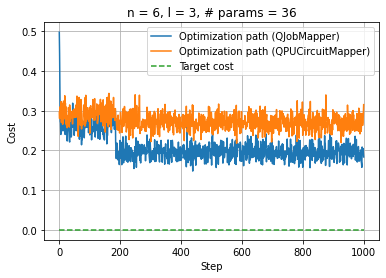

In [12]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.clf()
plt.plot(np.linspace(0, result.nit, result.nit), energies, label="Optimization path (QJobMapper)")
upper_bound = result.nit
plt.plot(np.linspace(0, result_.nit, result_.nit), energies_, label="Optimization path (QPUCircuitMapper)")
plt.plot(np.linspace(0, upper_bound, upper_bound), np.zeros(upper_bound), "--", label="Target cost")
plt.xlabel("Step"); plt.ylabel("Cost"); plt.legend(loc="upper right"); plt.title(f"n = {num_qubits}, l = {num_layers}, # params = {num_parameters}")
plt.grid(True)
plt.show()
# plt.savefig(f"optimization_de_n_{num_qubits}_p_{num_parameters}.png", dpi=200)

# Paralelization of expectation value terms

In [13]:
# TODO

# Paralelization for gradient optimizers

In [14]:
# TODO